In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import numpy as np
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer,HashingVectorizer
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from imblearn.over_sampling import SMOTE
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.cross_validation import StratifiedKFold 
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier
warnings.filterwarnings("ignore")

from mlxtend.classifier import StackingClassifier

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder,OneHotEncoder,LabelBinarizer
import nltk

# Loading the Data

In [3]:
data=pd.read_csv('training_variants')
print('Number of the Data points : ',data.shape[0])
print('Number of the Features : ',data.shape[1])
print('Features :',data.columns.values)
data.head()

Number of the Data points :  3321
Number of the Features :  4
Features : ['ID' 'Gene' 'Variation' 'Class']


,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2
3,3,CBL,N454D,3
4,4,CBL,L399V,4


In [4]:
len(data['Gene'])

3321

In [5]:
text_data=pd.read_csv('training_text',sep='\|\|',names=['ID','TEXT'],engine='python',skiprows=1)
print('Number of data points : ', text_data.shape[0])
print('Number of features : ', text_data.shape[1])
print('Features : ', text_data.columns.values)
text_data.head()

Number of data points :  3321
Number of features :  2
Features :  ['ID' 'TEXT']


,ID,TEXT
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...
2,2,Abstract Background Non-small cell lung canc...
3,3,Recent evidence has demonstrated that acquired...
4,4,Oncogenic mutations in the monomeric Casitas B...


In [6]:
stop_words=set(stopwords.words('english'))
def text_preprocessing(total_text,index,column):
    if type(total_text) is not int:
        string=""
        # replace every special char with space
        total_text=re.sub('[^a-zA-Z0-9\n]',' ',str(total_text))
        #Repalce multiple space with single space
        total_text=re.sub('\s+',' ',total_text)
        # converting all the chars into lower-case.
        total_text = total_text.lower()
        
        for word in total_text.split():
        # if the word is a not a stop word then retain that word from the data
            if not word in stop_words:
                string += word + " "
        
        text_data[column][index] = string       

In [7]:
#text processing stage.
start_time = time.clock()
for index, row in text_data.iterrows():
    text_preprocessing(row['TEXT'], index, 'TEXT')
print('Time took for preprocessing the text :',time.clock() - start_time, "seconds")

Time took for preprocessing the text : 363.41780437752783 seconds


In [8]:
#merging both gene_variations and text data based on ID
result = pd.merge(data,text_data,on='ID', how='left')
result.head()

,ID,Gene,Variation,Class,TEXT
0,0,FAM58A,Truncating Mutations,1,cyclin dependent kinases cdks regulate variety...
1,1,CBL,W802*,2,abstract background non small cell lung cancer...
2,2,CBL,Q249E,2,abstract background non small cell lung cancer...
3,3,CBL,N454D,3,recent evidence demonstrated acquired uniparen...
4,4,CBL,L399V,4,oncogenic mutations monomeric casitas b lineag...


# Spiliting the data best on the Train ,Test and CV

In [9]:
y_true=result['Class'].values
result.Variation = result.Variation.str.replace('\s+', '_')
result.Gene=result.Gene.str.replace('\s+','_')
# split the data into test and train by maintaining same distribution of output varaible 'y_true' [stratify=y_true]
X_train, test_df, y_train, y_test = train_test_split(result, y_true, stratify=y_true, test_size=0.2)
# split the train data into train and cross validation by maintaining same distribution of output varaible 'y_train' [stratify=y_train]
train_df, cv_df, y_train, y_cv = train_test_split(X_train, y_train, stratify=y_train, test_size=0.2)

# Coverting Gene and Variation features using LabelBinarizer()

In [10]:
one_encoder=LabelBinarizer()
train_one_hotencoder=one_encoder.fit_transform(train_df[['Gene']])

test_one_hotencoder=one_encoder.transform(test_df[['Gene']])
cv_one_hotencoder=one_encoder.transform(cv_df[['Gene']])


var_one_encoder=LabelBinarizer()
train_var_one_hotencoder=var_one_encoder.fit_transform(train_df[['Variation']])


test_var_one_hotencoder=var_one_encoder.transform(test_df[['Variation']])
cv_var_one_hotencoder=var_one_encoder.transform(cv_df[['Variation']])

In [11]:
train_one_hotencoder.shape

(2124, 232)

In [12]:
test_one_hotencoder.shape

(665, 232)

In [13]:
cv_one_hotencoder.shape

(532, 232)

In [14]:
train_var_one_hotencoder.shape

(2124, 1937)

In [15]:
test_var_one_hotencoder.shape

(665, 1937)

# Univariate analysis of Variation Feature

For values of alpha =  1e-05 The log loss is: 1.74364316967
For values of alpha =  0.0001 The log loss is: 1.73945758364
For values of alpha =  0.001 The log loss is: 1.73761555391
For values of alpha =  0.01 The log loss is: 1.74100545731
For values of alpha =  0.1 The log loss is: 1.74162761374
For values of alpha =  1 The log loss is: 1.73905065771


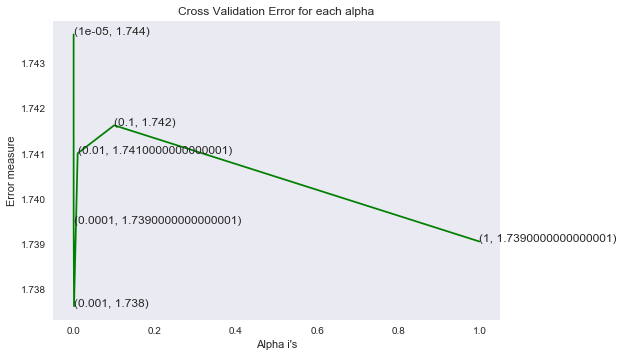

For values of best alpha =  0.001 The train log loss is: 1.18437743356
For values of best alpha =  0.001 The cross validation log loss is: 1.73761555391
For values of best alpha =  0.001 The test log loss is: 1.69592310625


In [16]:
alpha = [10 ** x for x in range(-5, 1)] # hyperparam for SGD classifier.
cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_var_one_hotencoder, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_var_one_hotencoder, y_train)
    predict_y = sig_clf.predict_proba(cv_var_one_hotencoder)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_var_one_hotencoder, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_var_one_hotencoder, y_train)

predict_y = sig_clf.predict_proba(train_var_one_hotencoder)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_var_one_hotencoder)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_var_one_hotencoder)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


# Univariate analysis Of Gene Feature

For values of alpha =  1e-05 The log loss is: 1.28754784659
For values of alpha =  0.0001 The log loss is: 1.21805740753
For values of alpha =  0.001 The log loss is: 1.20886010631
For values of alpha =  0.01 The log loss is: 1.30879943189
For values of alpha =  0.1 The log loss is: 1.35587197249
For values of alpha =  1 The log loss is: 1.36715710304


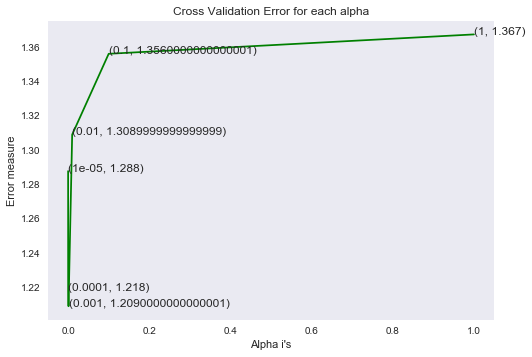

For values of best alpha =  0.001 The train log loss is: 1.11274259415
For values of best alpha =  0.001 The cross validation log loss is: 1.20886010631
For values of best alpha =  0.001 The test log loss is: 1.20336133167


In [17]:
alpha = [10 ** x for x in range(-5, 1)] # hyperparam for SGD classifier.
cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_one_hotencoder, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_one_hotencoder, y_train)
    predict_y = sig_clf.predict_proba(cv_one_hotencoder)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_one_hotencoder, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_one_hotencoder, y_train)

predict_y = sig_clf.predict_proba(train_one_hotencoder)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_one_hotencoder)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_one_hotencoder)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


# Vectorizing the Text data using HasingVectorizer()

In [18]:
hashing=HashingVectorizer(stop_words='english',ngram_range=(1,2),n_features=1000)

In [19]:
train_hash=hashing.transform(train_df['TEXT'])
test_hash=hashing.transform(test_df['TEXT'])
cv_hash=hashing.transform(cv_df['TEXT'])

In [20]:
train_text_hashing=normalize(train_hash,axis=0)
test_text_hashing=normalize(test_hash,axis=0)
cv_text_hashing=normalize(cv_hash,axis=0)

# Univariate analysis of Text Feature

For values of alpha =  1e-05 The log loss is: 1.11328565879
For values of alpha =  0.0001 The log loss is: 1.11924260934
For values of alpha =  0.001 The log loss is: 1.32765111758
For values of alpha =  0.01 The log loss is: 1.64031219286
For values of alpha =  0.1 The log loss is: 1.89361805885
For values of alpha =  1 The log loss is: 1.9695898673


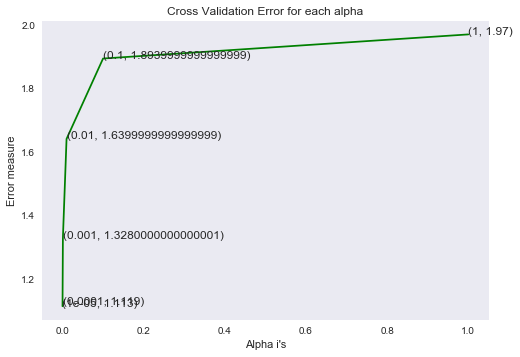

For values of best alpha =  1e-05 The train log loss is: 0.76945865005
For values of best alpha =  1e-05 The cross validation log loss is: 1.11328565879
For values of best alpha =  1e-05 The test log loss is: 1.0573885853


In [21]:
# Train a Logistic regression+Calibration model using text features whicha re on-hot encoded
alpha = [10 ** x for x in range(-5, 1)]

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------


cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_text_hashing, y_train)
    
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_text_hashing, y_train)
    predict_y = sig_clf.predict_proba(cv_text_hashing)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_text_hashing, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_text_hashing, y_train)

predict_y = sig_clf.predict_proba(train_text_hashing)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_text_hashing)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_text_hashing)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


In [22]:
#Data preparation for ML models.

#Misc. functionns for ML models


def predict_and_plot_confusion_matrix(train_x, train_y,test_x, test_y, clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    pred_y = sig_clf.predict(test_x)

    # for calculating log_loss we willl provide the array of probabilities belongs to each class
    print("Log loss :",log_loss(test_y, sig_clf.predict_proba(test_x)))
    # calculating the number of data points that are misclassified
    print("Number of mis-classified points :", np.count_nonzero((pred_y- test_y))/test_y.shape[0])
    plot_confusion_matrix(test_y, pred_y)

In [23]:
def report_log_loss(train_x, train_y, test_x, test_y,  clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    sig_clf_probs = sig_clf.predict_proba(test_x)
    return log_loss(test_y, sig_clf_probs, eps=1e-15)

# Stacking the three features 

In [24]:
train_gene_var_onehotCoding = np.hstack((train_one_hotencoder,train_var_one_hotencoder))
test_gene_var_onehotCoding = np.hstack((test_one_hotencoder,test_var_one_hotencoder))
cv_gene_var_onehotCoding = np.hstack((cv_one_hotencoder,cv_var_one_hotencoder))

In [25]:
train_x_onehotCoding = hstack((train_gene_var_onehotCoding, train_text_hashing))
train_y = np.array(list(train_df['Class']))

test_x_onehotCoding = hstack((test_gene_var_onehotCoding, test_text_hashing))
test_y = np.array(list(test_df['Class']))

cv_x_onehotCoding = hstack((cv_gene_var_onehotCoding, cv_text_hashing))
cv_y = np.array(list(cv_df['Class']))

In [26]:
print("One hot encoding features :")
print("(number of data points * number of features) in train data = ", train_x_onehotCoding.shape)
print("(number of data points * number of features) in test data = ", test_x_onehotCoding.shape)
print("(number of data points * number of features) in cross validation data =", cv_x_onehotCoding.shape)

One hot encoding features :
(number of data points * number of features) in train data =  (2124, 3169)
(number of data points * number of features) in test data =  (665, 3169)
(number of data points * number of features) in cross validation data = (532, 3169)


# Logistics Regression with Class Balancing

for alpha = 1e-06
Log Loss : 1.13914135961
for alpha = 1e-05
Log Loss : 1.0608423041
for alpha = 0.0001
Log Loss : 0.968819650997
for alpha = 0.001
Log Loss : 0.994616698863
for alpha = 0.01
Log Loss : 1.11478500838
for alpha = 0.1
Log Loss : 1.30268529613
for alpha = 1
Log Loss : 1.46663790192
for alpha = 10
Log Loss : 1.49160016524
for alpha = 100
Log Loss : 1.49476011567


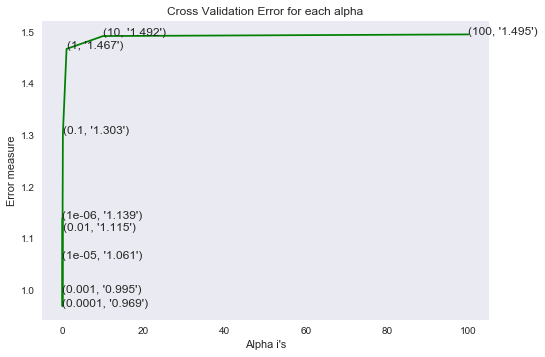

For values of best alpha =  0.0001 The train log loss is: 0.448145899614
For values of best alpha =  0.0001 The cross validation log loss is: 0.968819650997
For values of best alpha =  0.0001 The test log loss is: 0.900376634073


In [27]:
alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 
    
fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

# Conclusion / Summary

1.I have Imported all the neccesary libraries.
2. Loading the Gene and variation data
3. I have loaded the text data and removed the stopwords 
4. I have splitted the data set into Train,Test and CV
5 .I have applied the featurization technic to convert the gene and Variation features into feature vector here I have used 
   LabelBinarizer()
6. I have performed Univariate analysis on the Gene and Variation features
7. For text data , I have applied HashVectorizer() for the featurization purpose
8. I have stacked all the features including Gene,Variation and text
8. I have applied Logictic Regression with all the features and to the very extent I have reduced the cross validation and Test 
loss less than 1 
